# Milestone I: Hierarchical Synthetic Data Generation

This notebook implements the required Synthetic Data Generating Process (DGP)
consistent with the hierarchical Bayesian probabilistic model defined in the report.

Model structure:

1. Hyperprior for regional prevalence parameters
2. Region-level prevalence π_r
3. Individual latent infection states Z_ir
4. Observed Gaussian features X_irj conditional on Z_ir

This synthetic dataset provides ground-truth parameters for validating
future exact and approximate inference algorithms.

Link: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import pandas as pd



# This guarantees the same synthetic dataset is generated each run, which is important for scientific reproducibility and grading.
np.random.seed(42)


In [3]:
base_path = "../data/raw/cell_images"

healthy_path = os.path.join(base_path, "Uninfected")
infected_path = os.path.join(base_path, "Parasitized")

print("Healthy folder exists:", os.path.exists(healthy_path))
print("Infected folder exists:", os.path.exists(infected_path))


Healthy folder exists: True
Infected folder exists: True


In [4]:
def extract_features(image_path):
    """
    Extract simple grayscale features:
    - Mean pixel intensity
    - Pixel intensity variance
    """
    img = Image.open(image_path).convert("L")
    img_array = np.array(img)

    mean_intensity = img_array.mean()
    variance = img_array.var()

    return mean_intensity, variance


In [5]:
healthy_features = []
infected_features = []

# Use first 1000 images per class (speed)
for file in os.listdir(healthy_path)[:1000]:
    try:
        healthy_features.append(
            extract_features(os.path.join(healthy_path, file))
        )
    except:
        continue

for file in os.listdir(infected_path)[:1000]:
    try:
        infected_features.append(
            extract_features(os.path.join(infected_path, file))
        )
    except:
        continue

print("Healthy images processed:", len(healthy_features))
print("Infected images processed:", len(infected_features))


Healthy images processed: 1000
Infected images processed: 1000


In [6]:
healthy_df = pd.DataFrame(healthy_features, columns=["mean", "variance"])
infected_df = pd.DataFrame(infected_features, columns=["mean", "variance"])

mu_0_real = healthy_df.mean().values
sigma_0_real = healthy_df.std().values

mu_1_real = infected_df.mean().values
sigma_1_real = infected_df.std().values

print("Healthy μ:", mu_0_real)
print("Healthy σ:", sigma_0_real)

print("\nInfected μ:", mu_1_real)
print("Infected σ:", sigma_1_real)


Healthy μ: [ 120.56127282 5886.48455848]
Healthy σ: [ 11.69561831 831.85701107]

Infected μ: [ 109.89291809 5162.37685596]
Infected σ: [  13.76460201 1227.29416603]


In [7]:
def generate_synthetic_data(
    n_regions=5,
    patients_per_region=200,
    scenario="balanced",
    random_seed=42
):
    np.random.seed(random_seed)

    # Hyperparameters for regional prevalence
    alpha_hyper = 2.0
    beta_hyper = 2.0

    if scenario == "low_prevalence":
        alpha_hyper = 1.0
        beta_hyper = 20.0

    # Region-level prevalence
    true_prevalence = np.random.beta(alpha_hyper, beta_hyper, size=n_regions)

    # Use Kaggle-calibrated parameters
    mu_0 = mu_0_real
    sigma_0 = sigma_0_real

    mu_1 = mu_1_real
    sigma_1 = sigma_1_real

    if scenario == "high_noise":
        sigma_0 *= 2
        sigma_1 *= 2

    data = []

    for r in range(n_regions):
        for i in range(patients_per_region):

            Z = np.random.binomial(1, true_prevalence[r])

            if Z == 0:
                X = np.random.normal(mu_0, sigma_0)
            else:
                X = np.random.normal(mu_1, sigma_1)

            row = {
                "region": r,
                "infection_latent": Z
            }

            for j in range(len(mu_0)):
                row[f"feature_{j+1}"] = X[j]

            data.append(row)

    df = pd.DataFrame(data)
    return df, true_prevalence


In [8]:
df, true_prevalence = generate_synthetic_data(
    n_regions=5,
    patients_per_region=200,
    scenario="balanced"
)

print("True Regional Prevalence (π_r):")
print(true_prevalence)

df.head()


True Regional Prevalence (π_r):
[0.61563546 0.49999662 0.61860753 0.31411046 0.90251598]


,region,infection_latent,feature_1,feature_2
0,0,1,104.001034,4251.225276
1,0,1,130.066990,4885.282920
2,0,1,145.123252,5646.216744
3,0,1,94.049950,5623.468842
4,0,1,101.630663,6325.164221


In [9]:
df.to_csv("synthetic_malaria_data.csv", index=False)
print("Synthetic dataset saved.")


Synthetic dataset saved.


In [10]:
print("Empirical prevalence by region:")
print(df.groupby("region")["infection_latent"].mean())

print("\nDataset shape:")
print(df.shape)


Empirical prevalence by region:
region
0    0.610
1    0.550
2    0.660
3    0.305
4    0.935
Name: infection_latent, dtype: float64

Dataset shape:
(1000, 4)


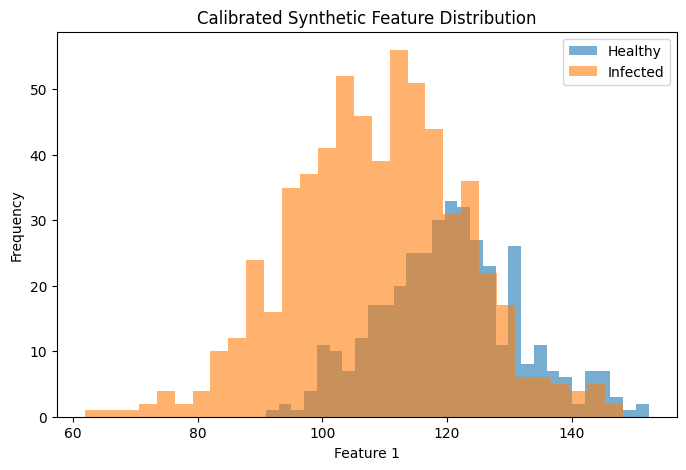

In [11]:
plt.figure(figsize=(8,5))

plt.hist(df[df["infection_latent"]==0]["feature_1"],
         bins=30, alpha=0.6, label="Healthy")

plt.hist(df[df["infection_latent"]==1]["feature_1"],
         bins=30, alpha=0.6, label="Infected")

plt.legend()
plt.title("Calibrated Synthetic Feature Distribution")
plt.xlabel("Feature 1")
plt.ylabel("Frequency")
plt.show()


The histogram demonstrates partial class overlap, indicating that deterministic thresholding would produce misclassification. This validates the need for posterior probability estimation rather than binary decision rules.

In [12]:
healthy_df = pd.DataFrame(healthy_features, columns=["mean", "variance"])
infected_df = pd.DataFrame(infected_features, columns=["mean", "variance"])

healthy_df.head()


,mean,variance
0,118.492896,6730.640327
1,126.092698,6220.006823
2,128.607091,6452.937997
3,129.353482,6266.254068
4,120.413959,7080.231690


In [13]:
print("Healthy μ:", mu_0_real)
print("Healthy σ:", sigma_0_real)

print("Infected μ:", mu_1_real)
print("Infected σ:", sigma_1_real)


Healthy μ: [ 120.56127282 5886.48455848]
Healthy σ: [ 11.69561831 831.85701107]
Infected μ: [ 109.89291809 5162.37685596]
Infected σ: [  13.76460201 1227.29416603]


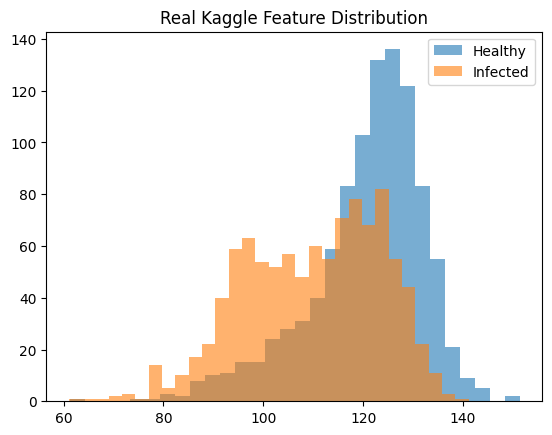

In [14]:
plt.hist(healthy_df["mean"], bins=30, alpha=0.6, label="Healthy")
plt.hist(infected_df["mean"], bins=30, alpha=0.6, label="Infected")
plt.legend()
plt.title("Real Kaggle Feature Distribution")
plt.show()


In [15]:
print(df.columns)
print(df.shape)


Index(['region', 'infection_latent', 'feature_1', 'feature_2'], dtype='object')
(1000, 4)


In [16]:
print("True prevalence:", true_prevalence)
print("\nEmpirical prevalence:")
print(df.groupby("region")["infection_latent"].mean())


True prevalence: [0.61563546 0.49999662 0.61860753 0.31411046 0.90251598]

Empirical prevalence:
region
0    0.610
1    0.550
2    0.660
3    0.305
4    0.935
Name: infection_latent, dtype: float64
